In [1]:
import numpy as np
import galsim
import matplotlib.pyplot as plt
from shrbk.data import get_galaxy_image

(section:deblending)=
# Deblending

## Definition

Blending is a phenomenon that happens in astronomical images when several objects are aligned when seen from Earth ; this causes the objects to be superposed on the images, making analysis of said objects difficult. Blending is of particular importance for weak lensing analysis, and even more so in next generation surveys which reach deeper magnitudes, tending to have more blended objects. This section is dedicated to methods which aim at recovering separate images of the objects in a blended scene ; you can find more about the impact of blending on shear measurement in {ref}`section:blendingbias`.

## Creating a blended image

First, we need to create blended images on which we can perform the deblending process. We will use Galsim to generate a simple exponential profile for galaxies, and apply shear to each of the galaxies. We will also convolve the galaxies with a simple Moffat PSF profile. Once we put the two galaxies together to form the blended scene, we perform shape measurement on the central galaxy, in order to evaluate later how performant our deblending was (as you can see, without deblending there is a large error in the measurement).

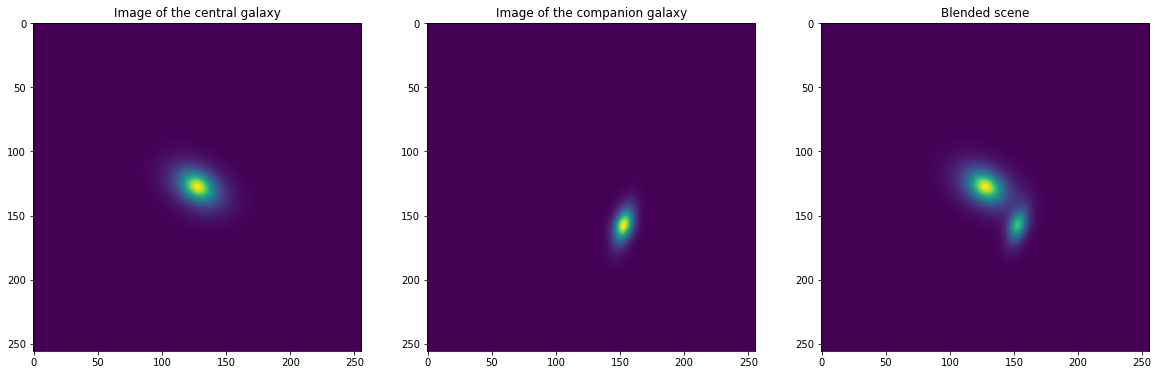

Shear measurement results on the central galaxy : g1 =  0.10282425582408905 , g2 =  0.20562252402305603
Relative error : δg1 =  2.824 %, δg2 =  2.811 %
Shear measurement results on the blended scene : g1 =  0.10958495736122131 , g2 =  0.2798094153404236
Relative error : δg1 =  9.585 %, δg2 =  39.905 %


In [2]:
# First we create the image of the central galaxy
image_central, image_psf = get_galaxy_image(gal_flux=1.e5,gal_r0=1.4,g1=0.1,g2=0.2,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2)
# Then we create the image of the companion galaxy
# The companion galaxy is dimmer (smaller gal_flux) and smaller (smaller gal_r0) than the central galaxy.
# You can note that it as a different shear than the central galaxy (g1 and g2).
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=5,shift_y=6)

# Finally we can add the two images together to create the blended scene.
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(image_central.array)
ax[0].set_title("Image of the central galaxy")
ax[1].imshow(image_companion.array)
ax[1].set_title("Image of the companion galaxy")
ax[2].imshow(blended_scene.array)
ax[2].set_title("Blended scene")
plt.show()

measured_shear = galsim.hsm.EstimateShear(image_central,image_psf,shear_est='KSB')
print("Shear measurement results on the central galaxy : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Relative error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results on the blended scene : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Relative error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

## Basic deblending

Now, we can explore one of the most basic ways of doing deblending, using the software Source Extractor ({cite}`SExtractor`), which assigns each pixel to a source, which of course is not a perfect solution but is relatively easy to implement. Here is what the result looks like, using the package `sep` ({cite}`Barbary2016`), a python implementation of Source Extractor. `sep` gives as a result a catalog containing the objects and a segmentation map associating each pixel with one of the galaxies (or to an empty area). We show the segmentation map obtained below.

In [3]:
import sep
img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)

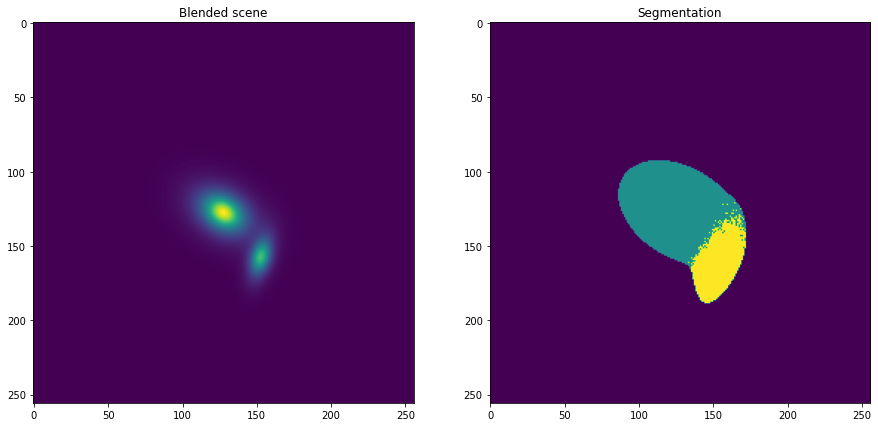

In [4]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow(blended_scene.array)
ax[0].set_title("Blended scene")
ax[1].imshow(segmentation)
ax[1].set_title("Segmentation")
plt.show()

Usin this segmentation map, we can extract a deblended image of the central galaxy, by keeping only the pixels associated with this galaxy.

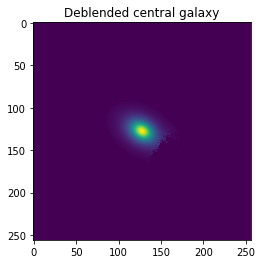

Shear measurement results : g1 =  0.10152844339609146 , g2 =  0.19612617790699005
Shear measurement error : δg1 =  1.528 %, δg2 =  -1.937 %


In [5]:
masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
plt.imshow(masked_scene)
plt.title("Deblended central galaxy")
plt.show()
measured_shear = galsim.hsm.EstimateShear(galsim.Image(masked_scene),image_psf,shear_est='KSB')
print("Shear measurement results : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Shear measurement error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

As you can see, the recovered image is close to the original galaxy and shape measurement is accurate again once the galaxy is deblended. However, this first example was manageable because the two galaxies were only blended a little. Let's see the result when the galaxies overlap more completely.

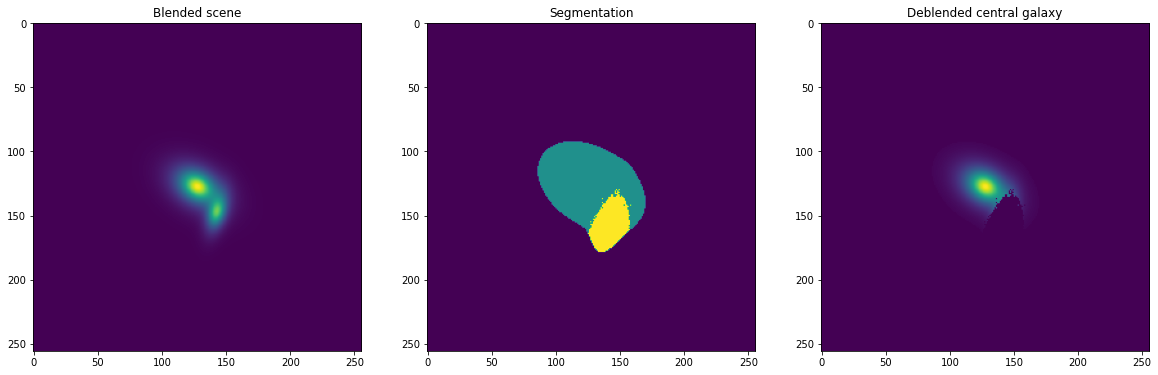

Shear measurement results on the blended scene : g1 =  -0.03829635679721832 , g2 =  0.4417387545108795
Relative error : δg1 =  -138.296 %, δg2 =  120.869 %
Shear measurement results on the deblended galaxy: g1 =  0.1317169964313507 , g2 =  0.13085855543613434
Shear measurement error : δg1 =  31.717 %, δg2 =  -34.571 %


In [11]:
# We keep the same galaxies as in the first exemple, except the companion is much closer.
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=3,shift_y=4)
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(blended_scene.array)
ax[0].set_title("Blended scene")

img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)
ax[1].imshow(segmentation)
ax[1].set_title("Segmentation")

masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
ax[2].imshow(masked_scene)
ax[2].set_title("Deblended central galaxy")

plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results on the blended scene : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Relative error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

measured_shear = galsim.hsm.EstimateShear(galsim.Image(masked_scene),image_psf,shear_est='KSB')
print("Shear measurement results on the deblended galaxy: g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Shear measurement error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

This time, a significant part of the central galaxy has been removed in the deblending process. This leads to a wildly inaccurate shear measurement. Let's see what happens when we bring the galaxies even closer to each other.

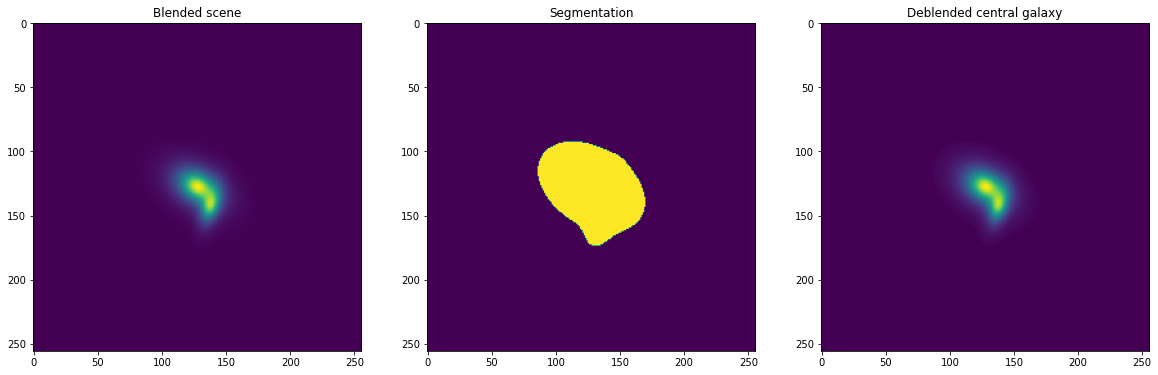

Shear measurement results on the blended scene : g1 =  -0.053492192178964615 , g2 =  0.30959129333496094
Relative error : δg1 =  -153.492 %, δg2 =  54.796 %


In [12]:
image_companion, _ = get_galaxy_image(gal_flux=3.e4,gal_r0=0.6,g1=-0.5,g2=-0.3,psf_beta=5,psf_re=1.0,
                                            pixel_scale=0.2,shift_x=2,shift_y=3)
blended_scene = galsim.ImageD(256,256)
blended_scene += image_central
blended_scene += image_companion

fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(blended_scene.array)
ax[0].set_title("Blended scene")

img = blended_scene.array
cat,segmentation = sep.extract(img,2,segmentation_map=True)
ax[1].imshow(segmentation)
ax[1].set_title("Segmentation")

masked_scene = blended_scene.array * np.where(segmentation == 1, 1, 0)
ax[2].imshow(masked_scene)
ax[2].set_title("Deblended central galaxy")

plt.show()

measured_shear = galsim.hsm.EstimateShear(blended_scene,image_psf,shear_est='KSB')
print("Shear measurement results on the blended scene : g1 = ",measured_shear.corrected_g1,", g2 = ",measured_shear.corrected_g2)
print("Relative error : \u03B4g1 = ",round((measured_shear.corrected_g1 - 0.1)/0.1 * 100,3),"%, \u03B4g2 = ",round((measured_shear.corrected_g2 - 0.2)/0.2*100,3),"%")

Here, SExtractor has been unable to perform deblending and identified the two galaxies as a single object. This situation is commonly called an "unrecognized blend" ; these are the most challenging blending situations to manage in a weak lensing survey as it is impossible to properly managed the blend, since it has not been identified.